# Generalized Vehicle Routing Problem

## Parser

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 12 22:46:37 2019

@author: andreamourelo
"""

from IPython.display import display, Markdown, Latex
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')
import csv
import numpy as np
import sys, getopt
import math

#def gvrp(filename, seed):
#print('Start processing file :', instance)

filename = 'GVRP/A-n32-k5-C11-V2.gvrp'
instance = (filename[:-5])
delimiter = ' '
#print(instance)

# No final, vamos ter:
# nodes = [node1, node2, ..., nodenNodes] = [[x_pos_node1, y_pos_node1, group_node_1], ....]
# com group_node entre [1, nGroups]

# e demands = [demand_group_1, demand_group_2, ..., demand_group_nGroups]
with open(filename,'r') as file:
    csv_reader = csv.reader(file,
                           delimiter = delimiter)
    line_count = 0
    node_count = 0
    group_count = 0
    nNodes, nGroups, nVehicles, capacity = 0,0,0,0
    for row in csv_reader:
        if line_count == 2 :  # DIMENSION : nNodes
            nNodes = int(row[2])
            nodes = np.zeros((nNodes,3), dtype=np.int)
        elif line_count == 3 : # VEHICLES : nVehicles
            nVehicles = int(row[2])
        elif line_count == 4 : # GVRP_SETS : nGroups
            nGroups = int(row[2])
            groups = [[0]] # Para guardar uma lista com os grupos
            demands = np.zeros((nGroups), dtype=np.int)
        elif line_count == 5 :
            capacity = int(row[2]) # CAPACITY : capacity
        elif line_count >= 8 and line_count <= 8 + nNodes +  - 1: # Informacoes sobre as posicoes dos nos => num x_pos y_pos
            nodes[node_count] = [int(row[1]),int(row[2]), 0] # Ainda nao temos info sobre o grupo do nó, no depot vai ter grupo 0 
            node_count += 1
        elif line_count >= 8 + nNodes + 1 and line_count <= 8 + nNodes + nGroups: # Informacoes sobre os grupos => num_grupo elem elem ... elem -1
            nNodesInGroup = len(row)
            group = []
            for numNode in range(1,nNodesInGroup - 1 ): # Para evitar o "-1" que mostra quando pular linha
                nodeOfGroup = int(row[numNode]) - 1
                nodes[nodeOfGroup][2]  = group_count + 1
                group.append(nodeOfGroup)
            group_count += 1
            groups.append(group)
            if group_count == nGroups:
                group_count = 0  # Reseteando no final para usar na leitura seguinte
        elif line_count >= 8 + nNodes + nGroups + 2 and line_count <= 8 + nNodes + 2*(nGroups + 1) - 1:
            demands[group_count] = int(row[1])
            group_count += 1
        line_count += 1

print(nNodes, nVehicles, nGroups, capacity)
print(nodes)
print(groups)
print(demands)  
    
    #print('Ending processing file :', instance)
    
#if __name__ == "__main__":
#    gvrp(sys.argv[1], seed) # Implement seed


32 2 11 100
[[82 76  0]
 [96 44  2]
 [50  5  6]
 [49  8  6]
 [13  7  1]
 [29 89  9]
 [58 30 10]
 [84 39 11]
 [14 24  1]
 [ 2 39  8]
 [ 3 82  3]
 [ 5 10  1]
 [98 52  2]
 [84 25 11]
 [61 59  5]
 [ 1 65  7]
 [88 51  2]
 [91  2  4]
 [19 32  8]
 [93  3  4]
 [50 93  9]
 [98 14  4]
 [ 5 42  8]
 [42  9  6]
 [61 62  5]
 [ 9 97  3]
 [80 55  2]
 [57 69  5]
 [23 15  1]
 [20 70  7]
 [85 60  2]
 [98  5  4]]
[[0], [11, 4, 8, 28], [12, 1, 16, 26, 30], [25, 10], [17, 19, 21, 31], [27, 14, 24], [3, 2, 23], [15, 29], [9, 18, 22], [20, 5], [6], [13, 7]]
[13 14 16 16 15 11 12  7  7 12 16]


## Auxiliary functions

In [2]:
import random

# Função usada para o set up da seed a cada função, pois se não não funcionava
def set_seed():
    # Set a seed value: 
    seed_value = 1001004  
    # 1. Set PYTHONHASHSEED environment variable at a fixed value: 
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value) 
    # 2. Set python built-in pseudo-random generator at a fixed value:
    random.seed(seed_value) 
    # 3. Set numpy pseudo-random generator at a fixed value:
    np.random.seed(seed_value) 

def createInitialSolutionRandomly(nVehicles, nGroups): # Doesnt YET check if the solution is FEASIBLE (capacities!!)
    # For now, creates list of np.arrays with each np.array being the route followed by a vehicle
    set_seed()
    routes = []
    for vehicle in range(nVehicles): # Preparing routes = [[],[],....,[]]
        routes.append([0])
    for group in range(nGroups): # Randomly assigning a vehicle for each group
        groupVehicle = random.randint(0,nVehicles - 1)
        routes[groupVehicle].append(group)
    for vehicle in range(nVehicles): # Preparing routes = [[],[],....,[]]
        routes.append(0)
    return routes
    #return [np.array(route) for route in routes]

def createInitialSolutionByBruteForce(nVehicles, nGroups, capacity, demands):
    routes = []
    for vehicle in range(nVehicles): # Preparing routes = [[],[],....,[]]
        routes.append([0]) # Todas começam em 0
    vehicleToFill = 0
    capacityFilled = 0
    capacities = []
    for group in range(1,nGroups):
        groupDemand = demands[group]
        space = capacity - capacityFilled
        if groupDemand < space:
            routes[vehicleToFill].append(group)
            capacityFilled += groupDemand
        else:
            capacities.append(capacityFilled)
            vehicleToFill += 1
            capacityFilled = 0
            routes[vehicleToFill].append(group)
            capacityFilled += groupDemand
    capacities.append(capacityFilled)
    #print('capacities : ',capacities)
    for vehicle in range(nVehicles): # Preparing routes = [[],[],....,[]]
        routes[vehicle].append(0) # Todas começam em 0
    return routes, capacities
    #return [np.array(route) for route in routes]
        
def localSearch(routes):
    return routes

def calculateDistance(routesWithNodes, distances):
    # We need nodes that are visited
    distance = 0
    for route in routesWithNodes:
        for node in range(len(route) - 1): # Evitating last one 
            #distance += distances[route[node]][route[node + 1]]
            distance = 0
    return distance

def perturbate(routes):
    return routes

def interPerturbation(route1, route2, routes):
    return routes

def intraPerturbation(route, group1, group2):
    return route

def twoOptIntra(route, group1, group2):
    # Will remove and replace 2 edges in the route
    # example: with route = [1,2,3,4,5,6,7,8], twoOptIntra(route, 2, 5) returns [1 2 3 6 5 4 7 8]
    temporary = route[group1 + 1 : group2]
    new_route = route[:group1 + 1] + [route[group2]] + temporary[::-1] + route[group2 + 1 : ]
    return new_route

def twoOptInter(route1, route2, group):
    # Will remove and replace 2 consecutive edges in two different routes
    # example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    # twoOptInter(route1, route2, 1)
    # will give (array([ 1,  2, 11, 12]), array([ 9, 10,  3,  4,  5,  6,  7,  8]))
    new_route1 = route1[:group + 1] + route2[group + 1 :]
    new_route2 = route2[:group + 1] + route1[group + 1 :]
    return new_route1, new_route2

def cross(route1, route2, group1, group2):
    # Will exchange 2 sequences of visits
    # example : with route1 = [1,2,3,4,5,6,7,8] and route2 = [9,10,11,12]
    # cross(route1, route2, 1, 3)
    # will return ([1, 2, 11, 12, 5, 6, 7, 8], [9, 10, 3, 4])    
    route1_temporary, route2_temporary = twoOptInter(route1, route2, group1)
    route1_final, route2_final = twoOptInter(route1_temporary, route2_temporary, group2)
    return route1_final, route2_final

def checkCapacity(route, demands, capacity):
    demandOfRoute = 0
    for group in route:
        demandOfRoute += demands[group]
        if demandOfRoute > capacity :
            return False
    return True

# def calculateDistanceAfterChange(route, ...??):



In [3]:
route1 = [1,2,3,4,5,6,7,8]
#print(twoOptIntra(route1, 2, 5))
route2 = [9,10,11,12]
#print(twoOptInter(route1, route2, 1))
print(cross(route1,route2,1,3))

([1, 2, 11, 12, 5, 6, 7, 8], [9, 10, 3, 4])


In [4]:
distances = np.full((nNodes,nNodes), 100000000000)

for node in range(0,nNodes):
    for second_node in range(node+1,nNodes):
        if nodes[node][2] != nodes[second_node][2]: # Nao queremos arestas entre os nós de um mesmo grupo
            x1, x2 = nodes[node][0], nodes[second_node][0]
            y1, y2 = nodes[node][1], nodes[second_node][1]
            distance2 = (x2 - x1)**2 + (y2 - y1)**2
            distances[node][second_node] = math.sqrt(distance2)
            distances[second_node][node] = math.sqrt(distance2)
            
print(pd.DataFrame(distances).head(8))

             0             1             2             3             4   \
0  100000000000            34            77            75            97   
1            34  100000000000            60            59            90   
2            77            60  100000000000  100000000000            37   
3            75            59  100000000000  100000000000            36   
4            97            90            37            36  100000000000   
5            54            80            86            83            83   
6            51            40            26            23            50   
7            37            13            48            46            77   

             5             6             7             8   9  ...   22  \
0            54            51            37            85  88 ...   84   
1            80            40            13            84  94 ...   91   
2            86            26            48            40  58 ...   58   
3            83            2

In [5]:
d1 = distances[1]
#d2 = d1[i for i in (7,13)]
print(d1)
d2 = np.array([d1[i] for i in (7,13)])
d2

[          34 100000000000           60           59           90
           80           40           13           84           94
          100           97 100000000000           22           38
           97 100000000000           42           77           41
           67           30           91           64           39
          101 100000000000           46           78           80
 100000000000           39]


array([13, 22])

In [6]:
def novasDistancias(distances, route, nNodes):
    nos = [0]
    novasDistancias = np.full((nNodes,nNodes), 100000000000) # copiamos matriz de distancias
    for i in range(len(route) - 1): # e mudamos valores para infinito quando nao sao do grupo
        group = route[i]
        next_group = route[i+1]
        nos_grupo = groups[next_group]
        nos += nos_grupo
        grupo1 = groups[group]
        grupo2 = groups[next_group]
        for node in grupo1:
            count = 0
            for i in range(nNodes):
                if i in grupo2:
                    count +=1
                    novasDistancias[node][i] = distances[node][i]
    #print(pd.DataFrame(novasDistancias))
    return novasDistancias
        
novasDistancias = novasDistancias(distances, [0,2,11,6], 32)

In [13]:
def FloydWarshall(novasDistancias):
    #print("Adjacency matrix")
    #print (distances)
    parent = []
    v = len(novasDistancias)
    # path reconstruction matrix
    p = np.zeros(novasDistancias.shape)
    for i in range(0,v):
        for j in range(0,v):
            p[i,j] = novasDistancias[i,j]


    # initialize to infinity
    for i in range (0, v):
        parent.append([])
        for j in range (0, v):
            parent[i].append(0)


    # initialize the path matrix
    for i in range (0,v):
        for j in range (0,v):
            if novasDistancias[i][j] == float("inf"):
                parent[i][j] = 0
            else:
                parent[i][j] = i


    changed = 0
    for k in range(0,v):
        for i in range(0,v):
            for j in range(0,v):
                if p[i,j] > p[i,k] + p[k,j]:
                    p[i,j] = p[i,k] + p[k,j]
                    parent[i][j] = parent[k][j]
                    changed +=1

    print("\n\n\n")
    #print(changed)
    #print(parent)


    # display shortest paths 

    # recursive function to obtain the path as a string
    def obtainPath(i, j):
        if novasDistancias[i][j] == float("inf"):
            return " no path to "
        if parent[i][j] == i:
            return " "
        else :
            return obtainPath(i, parent[i][j]) + str(parent[i][j]) + obtainPath(parent[i][j], j)


    for i in range (0,v):
        for j in range (0,v):
            if i == 0 and j == 23:
                print ("From :", i)
                print (" To :", j)
                print ("Path :" +  str(i) + obtainPath(i,j) + str(j))
                print ("Distance :", p[i][j])
                print("\n")
                
    print(pd.DataFrame(p))
                
FloydWarshall(novasDistancias)





From : 0
 To : 23
Path :0 16 7 23
Distance : 88.0


              0             1             2             3             4   \
0   1.000000e+11  3.400000e+01  8.500000e+01  8.300000e+01  1.000000e+11   
1   1.000000e+11  1.000000e+11  6.100000e+01  5.900000e+01  1.000000e+11   
2   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
3   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
4   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
5   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
6   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
7   1.000000e+11  1.000000e+11  4.800000e+01  4.600000e+01  1.000000e+11   
8   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
9   1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
10  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11  1.000000e+11   
11  1.000000e+11  1.000000e+11  

In [8]:
#def FloydWarshall(distances):
#print("Adjacency matrix")
#print (distances)
parent = []
v = len(distances)
# path reconstruction matrix
p = np.zeros(distances.shape)
for i in range(0,v):
    for j in range(0,v):
        p[i,j] = distances[i,j]


# initialize to infinity
for i in range (0, v):
    parent.append([])
    for j in range (0, v):
        parent[i].append(0)


# initialize the path matrix
for i in range (0,v):
    for j in range (0,v):
        if distances[i][j] == float("inf"):
            parent[i][j] = 0
        else:
            parent[i][j] = i


changed = 0
for k in range(0,v):
    for i in range(0,v):
        for j in range(0,v):
            if p[i,j] > p[i,k] + p[k,j]:
                p[i,j] = p[i,k] + p[k,j]
                parent[i][j] = parent[k][j]
                changed +=1
                
print("\n\n\n")
#print(changed)
#print(parent)


# display shortest paths 

# recursive function to obtain the path as a string
def obtainPath(i, j):
    if distances[i][j] == float("inf"):
        return " no path to "
    if parent[i][j] == i:
        return " "
    else :
        return obtainPath(i, parent[i][j]) + str(parent[i][j]+1) + obtainPath(parent[i][j], j)

        
for i in range (0,v):
    for j in range (0,v):
        print ("From :", i)
        print (" To :", j)
        print ("Path :" +  str(i) + obtainPath(i,j) + str(j))
        print ("Distance :", distances[i][j])
        print("\n")






From : 0
 To : 0
Path :0 31 0
Distance : 100000000000


From : 0
 To : 1
Path :0 1
Distance : 34


From : 0
 To : 2
Path :0 2
Distance : 77


From : 0
 To : 3
Path :0 7 3
Distance : 75


From : 0
 To : 4
Path :0 4
Distance : 97


From : 0
 To : 5
Path :0 5
Distance : 54


From : 0
 To : 6
Path :0 6
Distance : 51


From : 0
 To : 7
Path :0 7
Distance : 37


From : 0
 To : 8
Path :0 8
Distance : 85


From : 0
 To : 9
Path :0 28 9
Distance : 88


From : 0
 To : 10
Path :0 10
Distance : 79


From : 0
 To : 11
Path :0 11
Distance : 101


From : 0
 To : 12
Path :0 12
Distance : 28


From : 0
 To : 13
Path :0 13
Distance : 51


From : 0
 To : 14
Path :0 14
Distance : 27


From : 0
 To : 15
Path :0 15
Distance : 81


From : 0
 To : 16
Path :0 16
Distance : 25


From : 0
 To : 17
Path :0 17
Distance : 74


From : 0
 To : 18
Path :0 18
Distance : 76


From : 0
 To : 19
Path :0 19
Distance : 73


From : 0
 To : 20
Path :0 20
Distance : 36


From : 0
 To : 21
Path :0 17 21
Distance : 64


From

Distance : 26


From : 6
 To : 24
Path :6 24
Distance : 32


From : 6
 To : 25
Path :6 25
Distance : 83


From : 6
 To : 26
Path :6 26
Distance : 33


From : 6
 To : 27
Path :6 27
Distance : 39


From : 6
 To : 28
Path :6 28
Distance : 38


From : 6
 To : 29
Path :6 29
Distance : 55


From : 6
 To : 30
Path :6 30
Distance : 40


From : 6
 To : 31
Path :6 31
Distance : 47


From : 7
 To : 0
Path :7 0
Distance : 37


From : 7
 To : 1
Path :7 1
Distance : 13


From : 7
 To : 2
Path :7 2
Distance : 48


From : 7
 To : 3
Path :7 3
Distance : 46


From : 7
 To : 4
Path :7 4
Distance : 77


From : 7
 To : 5
Path :7 15 5
Distance : 74


From : 7
 To : 6
Path :7 6
Distance : 27


From : 7
 To : 7
Path :7 17 7
Distance : 100000000000


From : 7
 To : 8
Path :7 8
Distance : 71


From : 7
 To : 9
Path :7 9
Distance : 82


From : 7
 To : 10
Path :7 10
Distance : 91


From : 7
 To : 11
Path :7 7 11
Distance : 84


From : 7
 To : 12
Path :7 12
Distance : 19


From : 7
 To : 13
Path :7 2 13
Distance :

Distance : 26


From : 15
 To : 10
Path :15 10
Distance : 17


From : 15
 To : 11
Path :15 11
Distance : 55


From : 15
 To : 12
Path :15 12
Distance : 97


From : 15
 To : 13
Path :15 13
Distance : 92


From : 15
 To : 14
Path :15 14
Distance : 60


From : 15
 To : 15
Path :15 11 15
Distance : 100000000000


From : 15
 To : 16
Path :15 16
Distance : 88


From : 15
 To : 17
Path :15 17
Distance : 109


From : 15
 To : 18
Path :15 18
Distance : 37


From : 15
 To : 19
Path :15 19
Distance : 110


From : 15
 To : 20
Path :15 20
Distance : 56


From : 15
 To : 21
Path :15 21
Distance : 109


From : 15
 To : 22
Path :15 22
Distance : 23


From : 15
 To : 23
Path :15 23
Distance : 69


From : 15
 To : 24
Path :15 24
Distance : 60


From : 15
 To : 25
Path :15 25
Distance : 32


From : 15
 To : 26
Path :15 26
Distance : 79


From : 15
 To : 27
Path :15 27
Distance : 56


From : 15
 To : 28
Path :15 28
Distance : 54


From : 15
 To : 29
Path :15 11 29
Distance : 100000000000


From : 15
 To :

Path :23 29 3
Distance : 100000000000


From : 23
 To : 4
Path :23 4
Distance : 29


From : 23
 To : 5
Path :23 5
Distance : 81


From : 23
 To : 6
Path :23 6
Distance : 26


From : 23
 To : 7
Path :23 7
Distance : 51


From : 23
 To : 8
Path :23 8
Distance : 31


From : 23
 To : 9
Path :23 9
Distance : 50


From : 23
 To : 10
Path :23 10
Distance : 82


From : 23
 To : 11
Path :23 11
Distance : 37


From : 23
 To : 12
Path :23 12
Distance : 70


From : 23
 To : 13
Path :23 13
Distance : 44


From : 23
 To : 14
Path :23 14
Distance : 53


From : 23
 To : 15
Path :23 15
Distance : 69


From : 23
 To : 16
Path :23 16
Distance : 62


From : 23
 To : 17
Path :23 17
Distance : 49


From : 23
 To : 18
Path :23 18
Distance : 32


From : 23
 To : 19
Path :23 19
Distance : 51


From : 23
 To : 20
Path :23 20
Distance : 84


From : 23
 To : 21
Path :23 21
Distance : 56


From : 23
 To : 22
Path :23 22
Distance : 49


From : 23
 To : 23
Path :23 29 23
Distance : 100000000000


From : 23
 To : 24




From : 28
 To : 31
Path :28 31
Distance : 75


From : 29
 To : 0
Path :29 0
Distance : 62


From : 29
 To : 1
Path :29 1
Distance : 80


From : 29
 To : 2
Path :29 2
Distance : 71


From : 29
 To : 3
Path :29 3
Distance : 68


From : 29
 To : 4
Path :29 4
Distance : 63


From : 29
 To : 5
Path :29 5
Distance : 21


From : 29
 To : 6
Path :29 6
Distance : 55


From : 29
 To : 7
Path :29 7
Distance : 71


From : 29
 To : 8
Path :29 8
Distance : 46


From : 29
 To : 9
Path :29 9
Distance : 35


From : 29
 To : 10
Path :29 10
Distance : 20


From : 29
 To : 11
Path :29 11
Distance : 61


From : 29
 To : 12
Path :29 15 12
Distance : 80


From : 29
 To : 13
Path :29 13
Distance : 78


From : 29
 To : 14
Path :29 14
Distance : 42


From : 29
 To : 15
Path :29 11 15
Distance : 100000000000


From : 29
 To : 16
Path :29 16
Distance : 70


From : 29
 To : 17
Path :29 17
Distance : 98


From : 29
 To : 18
Path :29 18
Distance : 38


From : 29
 To : 19
Path :29 19
Distance : 99


From : 29
 To :

## Main function

In [9]:
## Data structures

# To stop algorithm
import timeit

# Distance matrix
#distances = np.zeros((nNodes,nNodes))

#for node in range(0,nNodes):
#    for second_note in range(node+1,nNodes):
#        x1, x2 = nodes[node][0], nodes[second_note][0]
#        y1, y2 = nodes[node][1], nodes[second_note][1]
#        distance2 = (x2 - x1)**2 + (y2 - y1)**2
#        distances[node][second_note] = distance2
#        distances[second_note][node] = distance2

#distances = np.sqrt(distances)
#print(distances)
#print(pd.DataFrame(distances).head())

## Create initial solution

# routes_initial = createInitialSolutionRandomly(nVehicles, nGroups)
routes_initial = createInitialSolutionByBruteForce(nVehicles, nGroups, capacity, demands)
print('initial routes : ', routes_initial)
routes = localSearch(routes_initial)
total_distance = calculateDistance(routes, distances)

## ILS

# Time setting
inicio = timeit.default_timer()
fim = timeit.default_timer() - 15
time = fim - inicio
#print(inicio,fim,time)
iterations = 0

while(time < 2): # 2 seconds max
    
    perturbated_routes = perturbate(routes)
    new_routes = localSearch(perturbated_routes)
    new_distance = calculateDistance(new_routes, distances)
    if new_distance < total_distance:
        total_distance = new_distance
        routes = new_routes
    iterations += 1
    #print(time)
    fim = timeit.default_timer()
    time = fim - inicio
    
print('number of iterations in 2 seconds : ', iterations)

initial routes :  ([[0, 1, 2, 3, 4, 5, 6, 7, 8, 0], [0, 9, 10, 0]], [98, 28])
number of iterations in 2 seconds :  889302


In [10]:
## Data structures

# To stop algorithm
import timeit

# Distance matrix
distances = np.zeros((nNodes,nNodes))

for node in range(0,nNodes):
    for second_note in range(node+1,nNodes):
        x1, x2 = nodes[node][0], nodes[second_note][0]
        y1, y2 = nodes[node][1], nodes[second_note][1]
        distance2 = (x2 - x1)**2 + (y2 - y1)**2
        distances[node][second_note] = distance2
        distances[second_note][node] = distance2

distances = np.sqrt(distances)
#print(distances)
#print(pd.DataFrame(distances).head())

# Time setting
inicio = timeit.default_timer()
fim = timeit.default_timer() - 15
time = fim - inicio
#print(inicio,fim,time)

iterations = 0
grand_iterations = 0

## ILS
ils_parameter = 3
min_total_distance = 1000000
routes = []

while(time < 2): # 2 seconds max
    ## Create initial solution
    # routes_initial = createInitialSolutionRandomly(nVehicles, nGroups)
    routes_initial, demand_distribution = createInitialSolutionByBruteForce(nVehicles, nGroups, capacity, demands)
    #print('initial routes : ', routes_initial)

    routes_iteration = localSearch(routes_initial) # Applying local search to find local minimum
    min_total_distance_iteration = calculateDistance(routes, distances)
    # Applying ils_parameter perturbations
    for i in range(ils_parameter): 
        perturbated_routes = perturbate(routes_iteration)
        new_routes = localSearch(perturbated_routes)
        new_distance = calculateDistance(new_routes, distances)
        if new_distance < min_total_distance_iteration:
            min_total_distance_iteration = new_distance
            routes_iteration = new_routes
        iterations += 1
    # Checking if the solution of this iteration is better than the global solution
    if min_total_distance_iteration < min_total_distance:
        min_total_distance = min_total_distance_iteration
        routes = routes_iteration
    grand_iterations += 1 

    fim = timeit.default_timer()
    time = fim - inicio

print('number of grand iterations and iterations in 2 seconds : ', grand_iterations, iterations)
print(routes)
print(demand_distribution)
print(calculateDistance(routes, distances))

number of grand iterations and iterations in 2 seconds :  115179 345537
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 0], [0, 9, 10, 0]]
[98, 28]
0


## Plot

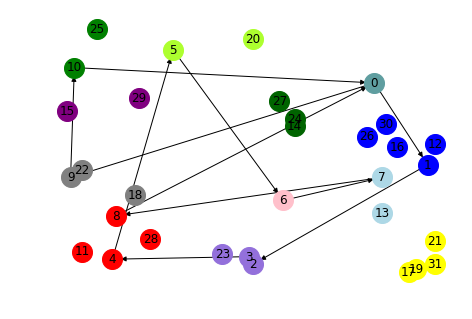

In [11]:
import networkx as nx
G = nx.DiGraph()

node = 1
#labels = {}
nodecolors = []
count_nodes = 0
for node in nodes:
    pos = [node[0],node[1]]
    G.add_node(count_nodes, pos = pos)
    G.node[count_nodes]['group'] = node[2]
    count_nodes+=1

# Mudar para pegar o elemento do grupo que é visitado POR GRUPO
for vehicleRoute in routes:
    for i in range(len(vehicleRoute) - 1):
        G.add_edge(vehicleRoute[i], vehicleRoute[i+1])
        
colors = ['cadetblue','red','blue','green','yellow', 'darkgreen', 'mediumpurple', 'purple', 'grey', 'greenyellow', 'pink', 'lightblue']
pos=nx.get_node_attributes(G,'pos')
#print(pos)
nx.draw(G, pos, with_labels = True)
for i in range(0,len(colors)):
    nodelist = []
    for node in G.nodes():
        #print(node)
        if G.node[node]['group'] == i:
            nodelist.append(node)
    nx.draw_networkx_nodes(G, pos=pos, nodelist=nodelist, node_size=400, node_color=colors[i], with_labels = True)
    #print(nodelist)
    i+=1